# Evaluate quantization on a simple model


In [1]:
import copy
import sys
import os
import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from matplotlib import pyplot as plt

# Add the parent directory to the path
sys.path.append(os.path.abspath(".."))
print(sys.path)

from core.quantization import quantize_model
from core.models.easy_quant import EasyQuantConfig
from core.models.squeeze_llm import SqueezeQuantConfig

['/opt/anaconda3/lib/python311.zip', '/opt/anaconda3/lib/python3.11', '/opt/anaconda3/lib/python3.11/lib-dynload', '', '/Users/deyucao/Library/Caches/pypoetry/virtualenvs/quantization-ubRKDRCl-py3.11/lib/python3.11/site-packages', '/var/folders/rx/ym13fcm14d568j0djggdjsrh0000gn/T/tmpg4a_gliw', '/Users/deyucao/Quantization']


## Train a simple model with only FC layers


**To keep the quantization process simple, I only used linear layers, which is sufficient for a simple task like MNIST classification.**


In [2]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 5
cal_dataset_size = 1000

# Dataset preprocessing
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Loading the MNIST dataset
train_dataset = datasets.FashionMNIST(
    root="./data", train=True, transform=transform, download=True
)
test_and_cal_dataset = datasets.FashionMNIST(
    root="./data", train=False, transform=transform, download=True
)

# Split the test dataset into test and calibration datasets
test_dataset, cal_dataset = random_split(
    test_and_cal_dataset, [10000 - cal_dataset_size, cal_dataset_size]
)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
cal_loader = DataLoader(dataset=cal_dataset, batch_size=cal_dataset_size, shuffle=False)


# Model definition
class SimpleLinearModel(nn.Module):
    def __init__(self):
        super(SimpleLinearModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Convert 28x28 image to 1D
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Initialize model, loss function, and optimizer
model = SimpleLinearModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Model testing
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Epoch [1/5], Loss: 0.5189
Epoch [2/5], Loss: 0.3797
Epoch [3/5], Loss: 0.3420
Epoch [4/5], Loss: 0.3188
Epoch [5/5], Loss: 0.2991
Test Accuracy: 86.33%


In [3]:
print(model)

SimpleLinearModel(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [4]:
# calculate and store the gradients of the loss for the calibration dataset
model.eval()

# Get the gradients of the loss w.r.t. the weights
for images, labels in cal_loader:
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()

In [5]:
for name, module in model.named_children():
    print(f"Layer: {name}, Module: {module}")

Layer: fc1, Module: Linear(in_features=784, out_features=128, bias=True)
Layer: fc2, Module: Linear(in_features=128, out_features=64, bias=True)
Layer: fc3, Module: Linear(in_features=64, out_features=10, bias=True)


In [4]:
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Checkpoint loaded. Model ready for use from epoch {start_epoch}.")
else:
    print("No checkpoint found.")

Checkpoint loaded. Model ready for use from epoch 1.


/var/folders/rx/ym13fcm14d568j0djggdjsrh0000gn/T/ipykernel_840/2738249724.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_lo

In [6]:
def display_and_predict(model: nn.Module, image: torch.Tensor) -> tuple[int, float]:
    """
    Display an input image and predict the digit using a given model.

    Args:
        model (nn.Module): The trained model for digit classification.
        image (torch.Tensor): The input image tensor of shape (1, 28, 28).

    Returns:
        tuple[int, float]: Predicted digit and the confidence (probability) of the prediction.
    """
    # Display the input image
    plt.imshow(image.squeeze(), cmap="gray")
    plt.axis("off")
    plt.show()

    # Preprocess the image (add batch dimension and flatten)
    image = image.view(-1, 28 * 28)  # Shape (1, 784)

    # Set model to evaluation mode and make prediction
    model.eval()
    with torch.no_grad():
        output = model(image)
        probabilities = torch.softmax(output, dim=1)
        predicted_label = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_label].item()

    print(f"Predicted Label: {predicted_label}, Confidence: {confidence:.4f}")
    return predicted_label, confidence

In [7]:
def evaluate_model(model: nn.Module, test_loader: DataLoader) -> float:
    """
    Evaluate the model on a test dataset and return the accuracy.

    Args:
        model (nn.Module): The trained model for digit classification.
        test_loader (DataLoader): DataLoader for the test dataset.

    Returns:
        float: The accuracy of the model on the test dataset.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

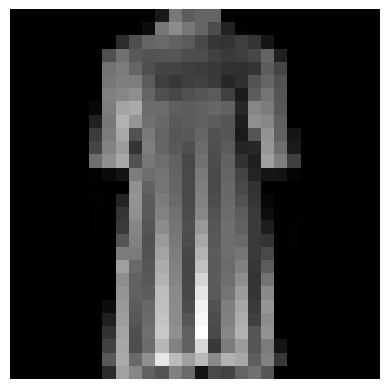

Predicted Label: 3, Confidence: 0.8902
True Label: 3


In [17]:
# Load a sample image from the test set
image, label = test_dataset[1]

# Display the image and make a prediction
predicted_label, confidence = display_and_predict(model, image)
print(f"True Label: {label}")

## Quantize the model with naive method


Below, all the quantization methods use 3-bit representation unless otherwise noted.


In [8]:
def quantize_model_naive(model: nn.Module, num_bits: int) -> nn.Module:
    """
    Naively quantize a model to the specified number of bits.

    Args:
        model (nn.Module): The model to quantize.
        num_bits (int): The number of bits to use for quantization.

    Returns:
        nn.Module: The quantized model.
    """
    quantized_model = copy.deepcopy(model)
    scale = 2 ** (num_bits - 1) - 1

    for (name, module), (name_q, module_q) in zip(
        model.named_modules(), quantized_model.named_modules()
    ):
        if isinstance(module, nn.Linear):
            for i in range(module.weight.data.shape[0]):
                original_weight = module.weight.data[i]
                max_val = torch.max(torch.abs(original_weight))
                print(f"Layer: {name}, channel {i} ,Max: {max_val}")
                print(f"Quantization range is: {max_val / scale}")
                module_q.weight.data[i] = (
                    torch.round(original_weight / (max_val / scale))
                    * (max_val / scale)
                )

    return quantized_model

In [9]:
quantized_model_naive = quantize_model_naive(model, num_bits=3)

Layer: fc1, channel 0 ,Max: 0.35536086559295654
Quantization range is: 0.11845362186431885
Layer: fc1, channel 1 ,Max: 0.22237606346607208
Quantization range is: 0.07412535697221756
Layer: fc1, channel 2 ,Max: 0.33834537863731384
Quantization range is: 0.11278179287910461
Layer: fc1, channel 3 ,Max: 0.3040206730365753
Quantization range is: 0.10134022682905197
Layer: fc1, channel 4 ,Max: 0.10032080858945847
Quantization range is: 0.03344026952981949
Layer: fc1, channel 5 ,Max: 0.30156299471855164
Quantization range is: 0.10052099823951721
Layer: fc1, channel 6 ,Max: 0.31340792775154114
Quantization range is: 0.10446930676698685
Layer: fc1, channel 7 ,Max: 0.35004010796546936
Quantization range is: 0.11668003350496292
Layer: fc1, channel 8 ,Max: 0.26554012298583984
Quantization range is: 0.08851337432861328
Layer: fc1, channel 9 ,Max: 0.4421647787094116
Quantization range is: 0.1473882645368576
Layer: fc1, channel 10 ,Max: 0.2849655747413635
Quantization range is: 0.09498852491378784
La

In [10]:
# Compare the weights of the original and quantized models
for (name, module), (name_q, module_q) in zip(
    model.named_modules(), quantized_model_naive.named_modules()
):
    if name == "fc1":
        print(f"Layer: {name}")
        print(f"Original Weights: {module.weight.data[:1, :10]}")
        print(f"Quantized Weights: {module_q.weight.data[:1, :10]}")
        print(module_q.weight.data[:1].max(), module_q.weight.data[:1].min())

Layer: fc1
Original Weights: tensor([[ 0.0263,  0.0155, -0.0133,  0.0298,  0.0578,  0.0150,  0.0745,  0.1274,
          0.2277,  0.2080]])
Quantized Weights: tensor([[0.0000, 0.0000, -0.0000, 0.0000, 0.0000, 0.0000, 0.1185, 0.1185, 0.2369,
         0.2369]])
tensor(0.3554) tensor(-0.3554)


In [11]:
# Evaluate the quantized model
accuracy_naive = evaluate_model(quantized_model_naive, test_loader)

Test Accuracy: 82.79%


**Observation**


Even the simplest naive quantization method can achieve a good accuracy with a simple model like this, with a degradation of only about 4%.


## Quantize the model with EasyQuant


### Without outlier isolation


In [12]:
config_easy = EasyQuantConfig(learning_rate=1e-3, num_epochs=100)

# Quantize the model

quantized_model_easy = quantize_model(
    model,
    "EasyQuant",
    config_easy,
    num_bits=3,
    verbose=True,
    retain_outliers=False,
)

Quantizing module: fc1
Using torch.int8 for quantization.
Quantizing 128 output channels
Quantization completed in 2.48 seconds
Quantizing module: fc2
Using torch.int8 for quantization.
Quantizing 64 output channels
Quantization completed in 1.45 seconds
Quantizing module: fc3
Using torch.int8 for quantization.
Quantizing 10 output channels
Quantization completed in 1.21 seconds


In [13]:
# Look at the parameters of each layer in the quantized model

for (name, module), (name_q, module_q) in zip(
    model.named_modules(), quantized_model_easy.named_modules()
):
    if name == "fc1":
        print(f"Layer: {name}")
        print(f"Original Weights: {module.weight.data[:1,:20]}")
        print(
            f"Quantized Weights: {module_q.quantization_executor.reconstruct_layer()[:1,:20]}"
        )

Layer: fc1
Original Weights: tensor([[ 0.0263,  0.0155, -0.0133,  0.0298,  0.0578,  0.0150,  0.0745,  0.1274,
          0.2277,  0.2080,  0.1752,  0.0559,  0.0654,  0.1111,  0.0797,  0.0335,
         -0.0209,  0.0666,  0.3014,  0.2802]])
Quantized Weights: tensor([[0.0000, 0.0000, 0.0000, 0.0586, 0.0586, 0.0000, 0.0586, 0.1172, 0.2344,
         0.2344, 0.1758, 0.0586, 0.0586, 0.1172, 0.0586, 0.0586, 0.0000, 0.0586,
         0.2344, 0.2344]])


By optimizing the quantization range to minimize reconstruction error, the reconstructed weights better resemble the original weights than the naive model.


In [14]:
# Evaluate the quantized model
accuracy_easy = evaluate_model(quantized_model_easy, test_loader)

Test Accuracy: 83.83%


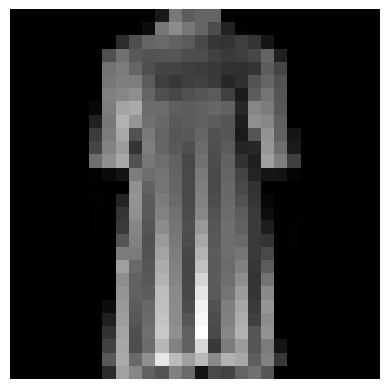

Predicted Label: 3, Confidence: 0.6365


In [18]:
# Load a sample image from the test set
image, label = test_dataset[1]

# Display the image and make a prediction
predicted_label, confidence = display_and_predict(quantized_model_easy, image)

**Obervation**


The EasyQuant method (without outlier isolation) was able to achieve a degradation of as little as 2.5 %.


### With outlier isolation


In [19]:
quantized_model_easy_out_iso = quantize_model(
    model,
    "EasyQuant",
    config_easy,
    num_bits=3,
    verbose=True,
    retain_outliers=True,
    outlier_threshold=2,
)

Quantizing module: fc1
Using torch.int8 for quantization.
Quantizing 128 output channels


/Users/deyucao/Quantization/core/models/easy_quant.py:298: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  outlier_weights = outlier_weights.to_sparse_csr()


Quantization completed in 2.28 seconds
Quantizing module: fc2
Using torch.int8 for quantization.
Quantizing 64 output channels
Quantization completed in 1.43 seconds
Quantizing module: fc3
Using torch.int8 for quantization.
Quantizing 10 output channels
Quantization completed in 1.27 seconds


In [20]:
# Look at the parameters of each layer in the quantized model

for (name, module), (name_q, module_q) in zip(
    model.named_modules(), quantized_model_easy_out_iso.named_modules()
):
    if name == "fc1":
        print(f"Layer: {name}")
        print(f"Original Weights: {module.weight.data[:1,:20]}")
        print(
            f"Quantized Weights: {module_q.quantization_executor.reconstruct_layer()[:1,:20]}"
        )

Layer: fc1
Original Weights: tensor([[ 0.0263,  0.0155, -0.0133,  0.0298,  0.0578,  0.0150,  0.0745,  0.1274,
          0.2277,  0.2080,  0.1752,  0.0559,  0.0654,  0.1111,  0.0797,  0.0335,
         -0.0209,  0.0666,  0.3014,  0.2802]])
Quantized Weights: tensor([[ 0.0351,  0.0000,  0.0000,  0.0351,  0.0703,  0.0000,  0.0703,  0.1406,
          0.2277,  0.2080,  0.1752,  0.0703,  0.0703,  0.1054,  0.0703,  0.0351,
         -0.0351,  0.0703,  0.3014,  0.2802]])


In [21]:
# Evaluate the quantized model
accuracy_easy_out_iso = evaluate_model(quantized_model_easy_out_iso, test_loader)

Test Accuracy: 84.07%


**Observation**


Outlier isolation in this case was able to recover the accuracy by about 0.25 %, which verifies the importance of outlier weights and more optimized quantization range with only normal weights.


## Quantize the model with SqueezeLLM


### Without Sensitivity-based weighting


In [22]:
config_squeeze = SqueezeQuantConfig(k_means_max_iter=100, use_sensitivity=False)

# Quantize the model

quantized_model_squeeze = quantize_model(
    model,
    "SqueezeQuant",
    config_squeeze,
    num_bits=3,
    verbose=True,
    retain_outliers=True,
    outlier_threshold=2,
)

Quantizing module: fc1
Using torch.int8 for quantization.
Quantizing 128 output channels
Quantization completed in 2.34 seconds
Quantizing module: fc2
Using torch.int8 for quantization.
Quantizing 64 output channels
Quantization completed in 1.58 seconds
Quantizing module: fc3
Using torch.int8 for quantization.
Quantizing 10 output channels
Quantization completed in 1.59 seconds


In [23]:
# Evaluate the quantized model
quantized_model_squeeze.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = quantized_model_squeeze(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Quantized Model Test Accuracy: {100 * correct / total:.2f}%")

Quantized Model Test Accuracy: 85.74%


**Observation**


The SqueezeLLM based quantization method (with outlier isolation but without sensitivity-based weighting) led to a decrease in accuracy of about 0.5 %.\
This result is even better than that of the EasyQuant algorithm, which indicates the effectiveness of non-uniform quantization method.


In [24]:
# Look at the parameters of each layer in the quantized model

for (name, module), (name_q, module_q) in zip(
    model.named_modules(), quantized_model_squeeze.named_modules()
):
    if name == "fc1":
        print(f"Layer: {name}")
        print(f"Original Weights: {module.weight.data[:1,:20]}")
        print(
            f"Quantized Normal Weights: {module_q.quantization_executor.normal_weights[:1,:20]}"
        )
        print(
            f"Reconstructed Weights: {module_q.quantization_executor.reconstruct_layer()[:1,:20]}"
        )

Layer: fc1
Original Weights: tensor([[ 0.0263,  0.0155, -0.0133,  0.0298,  0.0578,  0.0150,  0.0745,  0.1274,
          0.2277,  0.2080,  0.1752,  0.0559,  0.0654,  0.1111,  0.0797,  0.0335,
         -0.0209,  0.0666,  0.3014,  0.2802]])
Quantized Normal Weights: tensor([[ 1,  1, -4,  1, -3,  1, -3,  0, -4, -4, -4, -3, -3,  0, -3,  1, -1, -3,
         -4, -4]], dtype=torch.int8)
Reconstructed Weights: tensor([[ 0.0280,  0.0280, -0.0032,  0.0280,  0.0630,  0.0280,  0.0630,  0.1103,
          0.2277,  0.2080,  0.1752,  0.0630,  0.0630,  0.1103,  0.0630,  0.0280,
         -0.0316,  0.0630,  0.3014,  0.2802]])


### With Sensitivity-based weighting


In [25]:
config_squeeze_weighted = SqueezeQuantConfig(k_means_max_iter=100, use_sensitivity=True)

# Quantize the model

quantized_model_squeeze_weighted = quantize_model(
    model,
    "SqueezeQuant",
    config_squeeze_weighted,
    num_bits=3,
    verbose=True,
    retain_outliers=True,
    outlier_threshold=2,
)

Quantizing module: fc1
Using torch.int8 for quantization.
Quantizing 128 output channels
Quantization completed in 2.67 seconds
Quantizing module: fc2
Using torch.int8 for quantization.
Quantizing 64 output channels
Quantization completed in 1.63 seconds
Quantizing module: fc3
Using torch.int8 for quantization.
Quantizing 10 output channels
Quantization completed in 1.54 seconds


In [26]:
# Evaluate the quantized model
accuracy = evaluate_model(quantized_model_squeeze_weighted, test_loader)

Test Accuracy: 85.72%


In [68]:
# Look at the parameters of each layer in the quantized model

for (name, module), (name_q, module_q) in zip(
    model.named_modules(), quantized_model_squeeze_weighted.named_modules()
):
    if name == "fc1":
        print(f"Layer: {name}")
        print(f"Original Weights: {module.weight.data[:1,:20]}")
        print(
            f"Quantized Normal Weights: {module_q.quantization_executor.normal_weights[:1,:20]}"
        )
        print(
            f"Reconstructed Weights: {module_q.quantization_executor.reconstruct_layer()[:1,:20]}"
        )

Layer: fc1
Original Weights: tensor([[ 0.0450,  0.0145,  0.0132,  0.0735,  0.0662,  0.0706,  0.0331,  0.0595,
         -0.0001,  0.0194,  0.0090,  0.0231,  0.0112, -0.0571,  0.0014, -0.0363,
         -0.0093,  0.0543,  0.0987,  0.0547]])
Quantized Normal Weights: tensor([[ 3, -2, -2, -3, -3, -3,  3, -3,  0, -2, -2, -2, -2,  1,  0, -4,  0, -3,
          2, -3]], dtype=torch.int8)
Reconstructed Weights: tensor([[ 0.0388,  0.0143,  0.0143,  0.0648,  0.0648,  0.0648,  0.0388,  0.0648,
         -0.0075,  0.0143,  0.0143,  0.0143,  0.0143, -0.0647, -0.0075, -0.0352,
         -0.0075,  0.0648,  0.1079,  0.0648]])


**Observation**


Considering the sensitivity of weights in K-means clustering did not have any recognizable effect on the accuracy of the model.\
With many trials, the increase in accuracy averaged to about 0.1 %, which is negligible.


### Try with 2-bit representation


In [27]:
config_squeeze_weighted = SqueezeQuantConfig(k_means_max_iter=100, use_sensitivity=True)

# Quantize the model

quantized_model_squeeze_weighted_2bit = quantize_model(
    model,
    "SqueezeQuant",
    config_squeeze_weighted,
    num_bits=2,
    verbose=True,
    retain_outliers=True,
    outlier_threshold=2,
)

Quantizing module: fc1
Using torch.int8 for quantization.
Quantizing 128 output channels
Quantization completed in 2.42 seconds
Quantizing module: fc2
Using torch.int8 for quantization.
Quantizing 64 output channels
Quantization completed in 1.60 seconds
Quantizing module: fc3
Using torch.int8 for quantization.
Quantizing 10 output channels
Quantization completed in 1.51 seconds


In [28]:
# Evaluate the quantized model
accuracy = evaluate_model(quantized_model_squeeze_weighted_2bit, test_loader)

Test Accuracy: 85.12%


**Observation**


Only 2-bit (4 values) can achieve an almost comparable accuracy as the original float32 model, which is a remarkable result.


### Try with 1-bit representation


In [29]:
# Quantize the model

quantized_model_squeeze_weighted_1bit = quantize_model(
    model,
    "SqueezeQuant",
    config_squeeze_weighted,
    num_bits=1,
    verbose=True,
    retain_outliers=True,
    outlier_threshold=2,
)

Quantizing module: fc1
Using torch.int8 for quantization.
Quantizing 128 output channels
Quantization completed in 2.51 seconds
Quantizing module: fc2
Using torch.int8 for quantization.
Quantizing 64 output channels
Quantization completed in 1.53 seconds
Quantizing module: fc3
Using torch.int8 for quantization.
Quantizing 10 output channels
Quantization completed in 1.52 seconds


In [ ]:
accuracy = evaluate_model(quantized_model_squeeze_weighted_1bit, test_loader)

**Observation**


It looks like 2-bit was the bottom line for this model and dataset.
